<a href="https://colab.research.google.com/github/changsin/CV/blob/main/2.10.segmentation_thresholding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentation & Thresholding

## Otsu's Method: Optimal Global Thresholding

The best threshold $T$ is the one that minimizes the intra-class variance (variance within the foreground and background classes) or, equivalently, maximizes the inter-class variance (variance between the two classes).

Intra-Class Variance ($\sigma_W^2$):

$$\sigma_W^2(T) = \omega_0(T) \sigma_0^2(T) + \omega_1(T) \sigma_1^2(T)$$

- $\omega_0, \omega_1$: Probability of each (Background/Foreground).
- $\sigma_0^2, \sigma_1^2$: Variance of each class intensity.

Otsu's Algorithm: Iteratively search for $T$ (from 0 to 255) that minimizes $\sigma_W^2(T)$. The result is a highly effective, unsupervised binarization.


### Steps

1. Probability of Each Gray Level:
$$ p_i = \frac{n_i}{N} $$

- $ i $: gray level (from 0 to L-1)
- $ n_i $: number of pixels with intensity $i$
- $N$: total number of pixels in the image

2. Class Probabilities:
$$ \omega_1(t) = \sum_{i=0}^{t} p_i, \quad \omega_2(t) = \sum_{i=t+1}^{L-1} p_i $$

- $t$: threshold value (candidate intensity)
- $ \omega_1(t)$: probability (weight) of class 1 (background pixels)

- $ \omega_2(t)$: probability (weight) of class 2 (foreground pixels)
	​

- $p_i$: probability (normalized histogram) of intensity $i$
- $L$: number of possible gray levels (usually 256)

3. Class Means:
$$
\mu_1(t) = \frac{\sum_{i=0}^{t} i\,p_i}{\omega_1(t)}, \quad
\mu_2(t) = \frac{\sum_{i=t+1}^{L-1} i\,p_i}{\omega_2(t)}
$$
- $\mu_1(t)$: mean intensity of background class
- $\mu_2(t)$: mean intensity of foreground class

4. Global Mean:
$$
\mu_T = \sum_{i=0}^{L-1} i\,p_i
$$
- $\mu_T$: global mean

5. Between-Class Variance:
$$
\sigma_B^2(t) = \omega_1(t)\,[\mu_1(t) - \mu_T]^2
              + \omega_2(t)\,[\mu_2(t) - \mu_T]^2
$$

- $\sigma_B^2(t)$: between-class variance (measure of class separability)

Larger $\sigma_B^2(t)$ ⇒ better separation between foreground and background

6. Optimal Threshold
$$
t^* = \arg\max_t \sigma_B^2(t)
$$

(Optional) Compact form:
$$
\sigma_B^2(t) = \omega_1(t)\,\omega_2(t)\,[\mu_1(t) - \mu_2(t)]^2
$$

Otsu's optimal threshold = 169


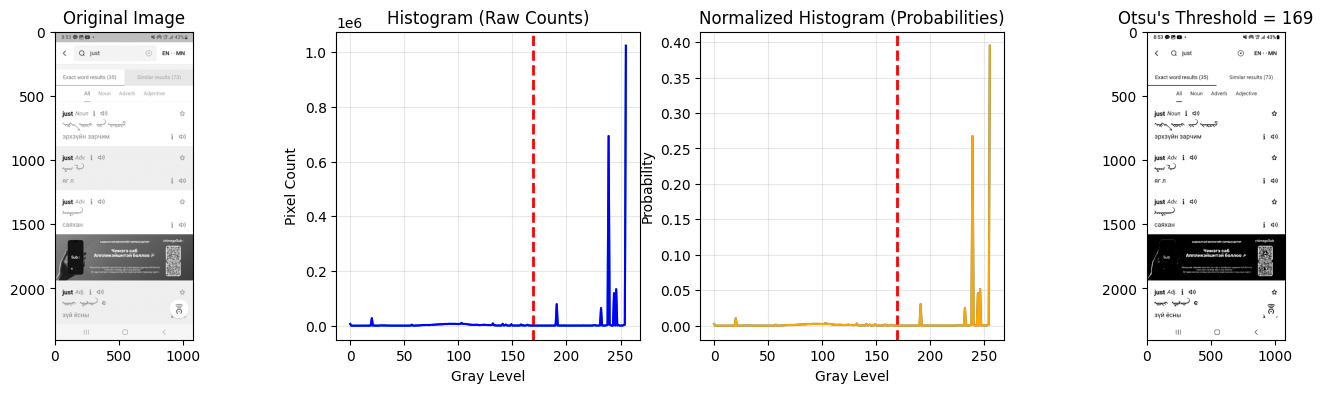

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load grayscale image
img = cv2.imread('Screenshot1.jpg', cv2.IMREAD_GRAYSCALE)

# Step 1: Compute histogram
hist, bins = np.histogram(img.ravel(), bins=256, range=(0, 256))
p = hist / hist.sum()  # normalized histogram (probabilities)

# Step 2: Compute cumulative sums and means
omega = np.cumsum(p)  # cumulative class probabilities
mu = np.cumsum(p * np.arange(256))  # cumulative means

# Step 3: Global mean
mu_t = mu[-1]

# Step 4: Compute between-class variance
sigma_b_squared = (mu_t * omega - mu)**2 / (omega * (1 - omega) + 1e-10)

# Step 5: Find threshold that maximizes variance
T = np.argmax(sigma_b_squared)

print("Otsu's optimal threshold =", T)

# Step 6: Apply threshold
_, otsu_img = cv2.threshold(img, T, 255, cv2.THRESH_BINARY)

# Display results
plt.figure(figsize=(18,4))

plt.subplot(1,4,1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')

plt.subplot(1,4,2)
plt.plot(hist) # Plot the original histogram
plt.axvline(T, color='r', linestyle='dashed', linewidth=2)
# plt.title('Original Histogram')
# plt.xlabel('Pixel Intensity')
# plt.ylabel('Frequency')
plt.plot(hist, color='blue')
plt.title('Histogram (Raw Counts)')
plt.xlabel('Gray Level')
plt.ylabel('Pixel Count')
plt.grid(True, alpha=0.3)


plt.subplot(1,4,3)
plt.plot(p) # Plot the normalized histogram
plt.axvline(T, color='r', linestyle='dashed', linewidth=2) # Threshold should not be scaled for normalized histogram
# plt.title('Normalized Histogram')
# plt.xlabel('Pixel Intensity') # Label remains Pixel Intensity
# plt.ylabel('Probability')
plt.plot(p, color='orange')
plt.title('Normalized Histogram (Probabilities)')
plt.xlabel('Gray Level')
plt.ylabel('Probability')
plt.grid(True, alpha=0.3)

plt.subplot(1,4,4)
plt.imshow(otsu_img, cmap='gray')
plt.title(f"Otsu's Threshold = {T}")

plt.show()

Otsu's optimal threshold = 169


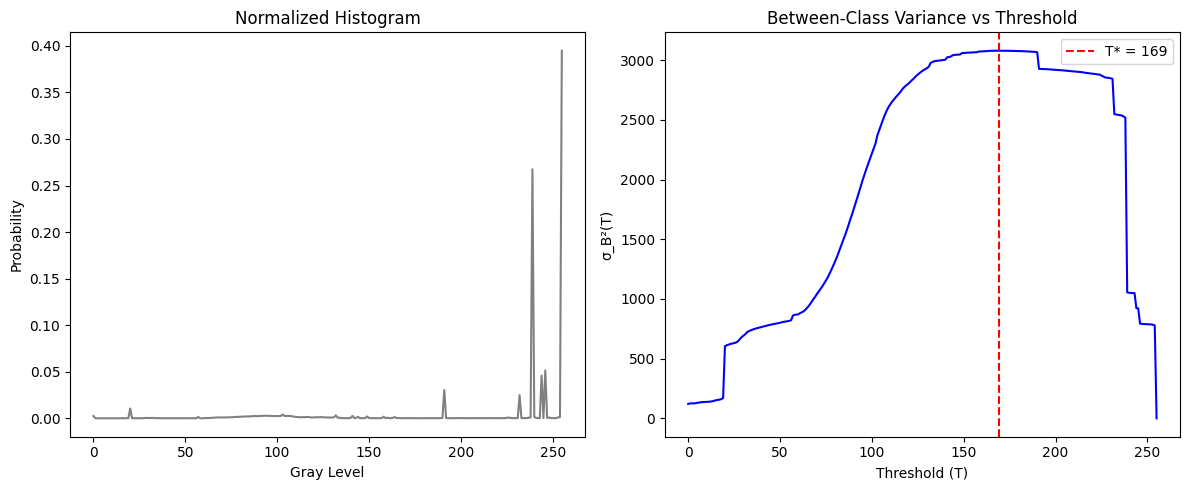

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load grayscale image
img = cv2.imread('Screenshot1.jpg', cv2.IMREAD_GRAYSCALE)

# Compute normalized histogram
hist, bins = np.histogram(img.ravel(), bins=256, range=(0, 256))
p = hist / hist.sum()

# Cumulative sums and means
omega = np.cumsum(p)
mu = np.cumsum(p * np.arange(256))
mu_t = mu[-1]

# Compute between-class variance for all thresholds
sigma_b_squared = (mu_t * omega - mu)**2 / (omega * (1 - omega) + 1e-10)

# Find optimal threshold
T_opt = np.argmax(sigma_b_squared)
print("Otsu's optimal threshold =", T_opt)

# --- Visualization ---
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(p, color='gray')
plt.title('Normalized Histogram')
plt.xlabel('Gray Level')
plt.ylabel('Probability')

plt.subplot(1,2,2)
plt.plot(sigma_b_squared, color='blue')
plt.axvline(T_opt, color='red', linestyle='--', label=f'T* = {T_opt}')
plt.title('Between-Class Variance vs Threshold')
plt.xlabel('Threshold (T)')
plt.ylabel('σ_B²(T)')
plt.legend()

plt.tight_layout()
plt.show()


## Adaptive Thresholding

In [12]:
# Adaptive Mean Thresholding
mean = cv2.adaptiveThreshold(img, 255,
            cv2.ADAPTIVE_THRESH_MEAN_C,
            cv2.THRESH_BINARY, 11, 2)

# Adaptive Gaussian Thresholding
gauss = cv2.adaptiveThreshold(img, 255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY, 11, 2)


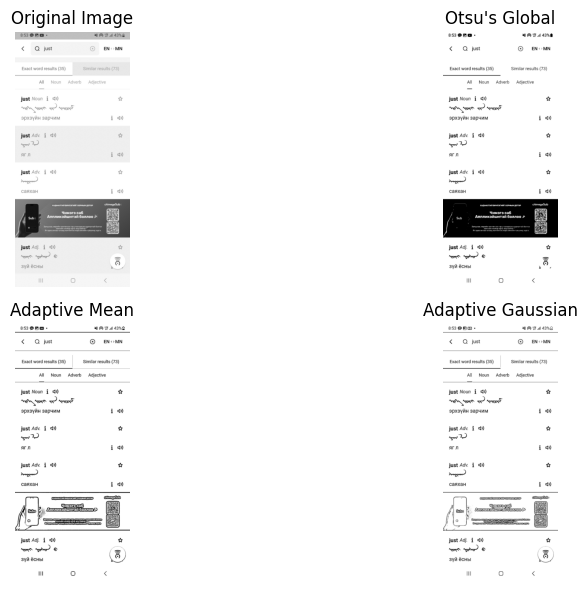

In [13]:
import cv2
import matplotlib.pyplot as plt

# Load grayscale image
img = cv2.imread('Screenshot1.jpg', cv2.IMREAD_GRAYSCALE)

# Global threshold using Otsu's method
_, otsu = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Adaptive Mean Thresholding
adaptive_mean = cv2.adaptiveThreshold(
    img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 15, 10)

# Adaptive Gaussian Thresholding
adaptive_gauss = cv2.adaptiveThreshold(
    img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 10)

# Display results
titles = ['Original Image', "Otsu's Global", 'Adaptive Mean', 'Adaptive Gaussian']
images = [img, otsu, adaptive_mean, adaptive_gauss]

plt.figure(figsize=(12,6))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')

plt.tight_layout()
plt.show()
